In [1]:
import numpy as np
from tqdm import tqdm
from time import time
from PIL import Image

import torch
import torch.nn as nn

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from archface import LResNet100
from privacy_pipeline import Pipeline

In [3]:
IMAGE = "./images/0.jpg"
DEVICE = torch.device("cuda")

net = LResNet100().eval().to(DEVICE)
net.load_state_dict(torch.load("torchtest.pt"))

batch_size = 80
image_dim = 112

def preprocess_image_tensors(im):
    im = im - 0.5
    im = im * 2
    return im

im_target = torch.FloatTensor(np.transpose(np.array(Image.open(IMAGE)),(2,0,1))).to(DEVICE) / 255
im_target = nn.Upsample(size = (image_dim,image_dim))(im_target[None].to(DEVICE))

with torch.no_grad():
    emb_target = net(preprocess_image_tensors(im_target))
    
pipeline = Pipeline(emb_target,
                    net,
                    DEVICE,
                    dim=image_dim,
                    batch_size=batch_size,
                    sym_part=1,
                    multistart=True,
                    gauss_amplitude=0.02
                    )

In [4]:
cosines_target = []
facenet_sims = []

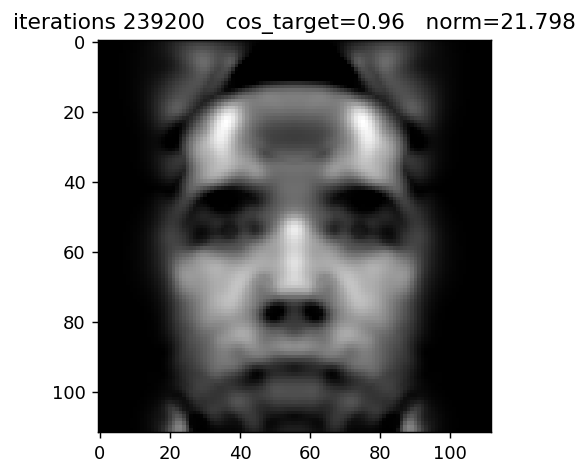

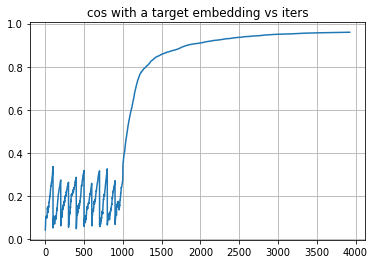

In [6]:
with torch.no_grad():
    for i in range(3000):
        start = time()
        
        recovered_face, cos_target = pipeline()
        
        cosines_target.append(cos_target)
        
        
        if i % 10 == 0:
            clear_output(wait=True)
            recovered_face = np.transpose(recovered_face.cpu().detach().numpy(),(1,2,0))
            recovered_face = recovered_face - np.min(recovered_face)
            recovered_face = recovered_face / np.max(recovered_face)
            
            plt.figure(dpi=130)
            plt.imshow(recovered_face)
            plt.title(f"iterations {i*pipeline.batch_size}   cos_target={round(cos_target,3)}   norm={round(pipeline.norm,3)}")
            plt.show()
            
            plt.plot(cosines_target)
            plt.grid()
            plt.title("cos with a target embedding vs iters")
            plt.show()
            